### result

In [10]:
!python pascalvoc.py -det ../yolov5/runs/detect/exp5/labels -gt ../yolov5/data/coco-ev/labels/valid/ -detcoords rel -gtcoords rel -imgsize 640,640

Figure(640x480)
Figure(640x480)
AP: 57.00% (0)
AP: 57.95% (1)
mAP: 57.47%


In [11]:
import pandas as pd
events = pd.read_csv('events.csv')

In [13]:
results=events.groupby(['name', 'event']).size().unstack().fillna(0)

In [14]:
results['missed'] = results['gt'] - results['tp']

In [15]:
results.sort_values('missed', ascending=False)

event              fp    gt    tp  missed
name                                     
image_000001141   4.0  39.0  16.0    23.0
image_000001248   1.0  31.0  10.0    21.0
image_000001180   4.0  30.0  10.0    20.0
image_000001001   3.0  25.0   8.0    17.0
image_000001032  10.0  23.0   8.0    15.0
...               ...   ...   ...     ...
image_000001205   1.0   2.0   2.0     0.0
image_000001200   1.0   4.0   4.0     0.0
image_000001197   9.0   3.0   3.0     0.0
image_000001189   0.0   4.0   4.0     0.0
image_000001400   1.0   7.0   7.0     0.0

[400 rows x 4 columns]

### plot images with detections

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import cv2

In [17]:
cv2_image = lambda x: cv2.imread(
    '../yolov5/data/coco-ev/images/valid/%s.jpg' %x
)

In [18]:
ground_truth_for = lambda x: pd.read_csv(
    '../yolov5/data/coco-ev/labels/valid/%s.txt' %x,
    delimiter=' ', header=None#['class', 'x', 'y', 'w', 'h'],del
).values

In [47]:
detections_for = lambda x: pd.read_csv(
    '../yolov5/runs/detect/exp5/labels/%s.txt' %x,
    delimiter=' ', header=None#['class', 'x', 'y', 'w', 'h'],del
).values

In [48]:
label_map = {
    0 : 'Person',
    1 : 'Car'
}

In [74]:
pointwidth_to_x1x2 = lambda x_mid, w: (x_mid-(w/2), x_mid+(w/2))
absolute_pointwidth_to_x1x2 = lambda x_mid, x_max, w: [
    int(x_max*(v)) for v in pointwidth_to_x1x2(x_mid, w)
]

def plot_box(img, x_max, y_max, box, color, label=None):
    x_mid, y_mid, w, h = box
    x1, x2 = absolute_pointwidth_to_x1x2(x_mid, x_max, w)
    y1, y2 = absolute_pointwidth_to_x1x2(y_mid, y_max, h)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    if label:
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

def plot_boxes(img, boxes, color, labels=None):
    y_max, x_max, _ = img.shape
    for i, box in enumerate(boxes):
        label = label_map[labels[i]] if labels is not None else None 
        img = plot_box(img, x_max, y_max, box, color, label)
    return img

In [75]:
def get_saved_data_for_img(img_name):
    img = cv2_image(img_name)#[:, :, ::-1]
    gt = ground_truth_for(img_name)
    de = detections_for(img_name)
    return img, gt, de
    
def ploted_predictions(img_name):
    ground_truth_color = (100, 255, 100)
    detection_color = (100, 100, 255)
    img, gt, de = get_saved_data_for_img(img_name)
    img = plot_boxes(img, gt[:,1:5], ground_truth_color, gt[:,0])
    img = plot_boxes(img, de[:,1:5], detection_color, de[:,0])
    return img

In [76]:
img_name = 'image_000001141'


In [77]:
result_sort = results.sort_values('missed', ascending=False)

#### view detections on images with more objects

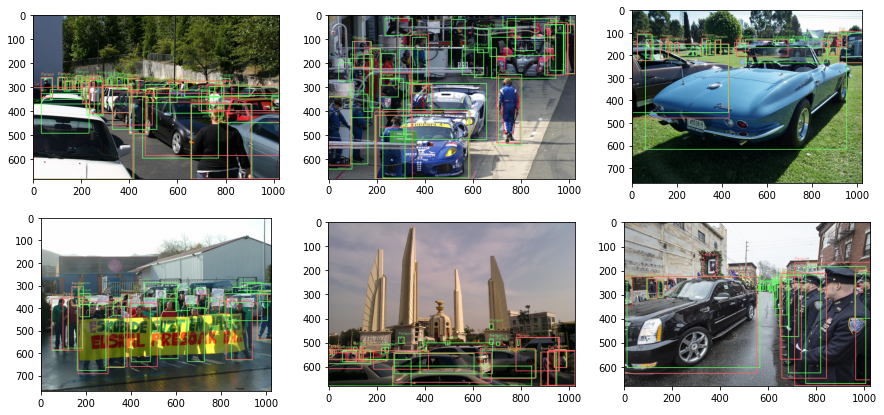

In [79]:
plt.figure(figsize=(15,7))
for i in range(6):
    name = result_sort.index[i]
    img = ploted_predictions(name)
    plt.subplot(2,3,i+1)
    plt.imshow(img[:, :, ::-1])

#### num of obj present vs false negative

<AxesSubplot:xlabel='gt'>

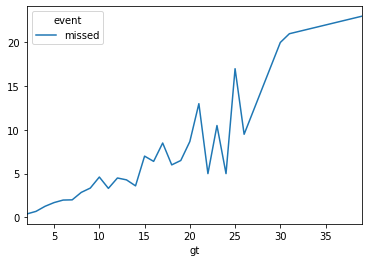

In [101]:
result_sort['is_missed'] = (result_sort['missed']>0).astype(int)
result_sort[['gt', 'missed']].groupby('gt').mean().plot()

<AxesSubplot:xlabel='gt'>

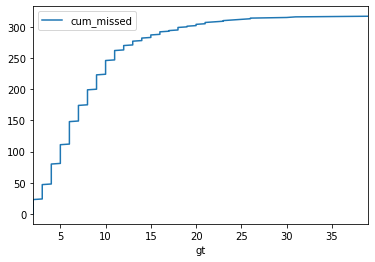

In [92]:
result_sort['cum_missed'] = (result_sort['missed']>0).astype(int).cumsum()
result_sort.plot(x='gt', y='cum_missed')

#### view images with less object

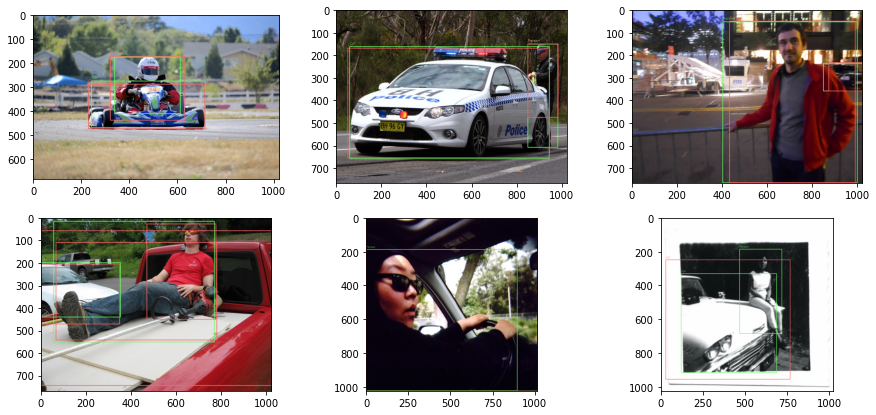

In [80]:
result_sort = results.sort_values('gt', ascending=True)
plt.figure(figsize=(15,7))
for i in range(6):
    name = result_sort.index[i]
    img = ploted_predictions(name)
    plt.subplot(2,3,i+1)
    plt.imshow(img[:, :, ::-1])